In [1]:
import os
import pickle
import copy

import torch
import torch_geometric
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glycowork.glycan_data.loader import lib

from glycontact.lwca import LinearWarmupCosineAnnealingLR
from glycontact.visualize import extract_torsion_angles
from glycontact.learning import GINSweetNet, VonMisesSweetNet, create_dataset, train_model, clean_split, build_baselines, evaluate_model

# Seed everything for reproducibility
torch_geometric.seed_everything(42)

/home/rjo21/miniconda3/envs/glycontact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sh: cd-hit: command not found
sh: cd-hit-est: command not found
sh: diamond: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mash: command not found
sh: foldseek: command not found
sh: TMalign: command not found


## Data Preprocessing

In [2]:
if not os.path.exists("conformer_split.pkl"):
    multi_train, multi_test = create_dataset()
    with open("conformer_split.pkl", "wb") as f:
        pickle.dump((multi_train, multi_test), f)
else:
    with open("conformer_split.pkl", "rb") as f:
        multi_train, multi_test = pickle.load(f)

# clean_test = clean_split(test, mode="mean")
train = clean_split(multi_train, mode="max")
test = clean_split(multi_test, mode="max")

## Model Training

#### Single Conformer

In [3]:
# Monomer baselines
mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor = build_baselines([d[1] for d in train], np.mean)
median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor = build_baselines([d[1] for d in train], np.median)

In [4]:
model = GINSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = LinearWarmupCosineAnnealingLR(optimizer=optim, warmup_epochs=25, max_epochs=50, warmup_start_lr=1e-5, eta_min=1e-7)
metrics, model = train_model(
    model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in multi_train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in multi_test], batch_size=64),
    },
    optim,
    scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 10.7441 Phi: 1.5142 Psi: 2.9299 SASA: 223.2038 Flex: 2.5800 LR: 0.0000
val Loss: 10.9295 Phi: 1.5423 Psi: 2.9229 SASA: 222.2065 Flex: 2.7608 LR: 0.0000

Epoch 1/149
----------
train Loss: 10.5919 Phi: 1.5118 Psi: 2.9280 SASA: 223.1330 Flex: 2.4332 LR: 0.0001
val Loss: 10.6911 Phi: 1.5384 Psi: 2.9204 SASA: 222.1254 Flex: 2.5302 LR: 0.0001

Epoch 2/149
----------
train Loss: 10.2888 Phi: 1.5085 Psi: 2.9273 SASA: 222.9515 Flex: 2.1371 LR: 0.0001
val Loss: 10.1292 Phi: 1.5339 Psi: 2.9197 SASA: 221.8912 Flex: 1.9774 LR: 0.0001

Epoch 3/149
----------
train Loss: 9.8244 Phi: 1.5050 Psi: 2.9271 SASA: 222.8969 Flex: 1.6774 LR: 0.0001
val Loss: 9.8642 Phi: 1.5318 Psi: 2.9204 SASA: 221.6287 Flex: 1.7182 LR: 0.0001

Epoch 4/149
----------
train Loss: 9.5626 Phi: 1.5038 Psi: 2.9276 SASA: 222.6855 Flex: 1.4197 LR: 0.0002
val Loss: 9.7175 Phi: 1.5310 Psi: 2.9188 SASA: 221.3664 Flex: 1.5783 LR: 0.0002

Epoch 5/149
----------
train Loss: 9.4350 Phi: 1.4994 Psi: 2.927

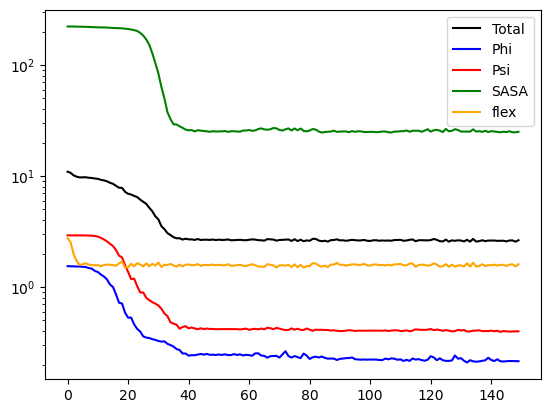

In [5]:
plt.plot(metrics["val"]["loss"], c="black", label="Total")
plt.plot(metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [6]:
print("Mean Predictor")
mean_phi_rmse, mean_psi_rmse, mean_sasa_rmse, mean_flex_rmse, mean_preds = \
    evaluate_model((mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor), test)
print(mean_phi_rmse, mean_psi_rmse, mean_sasa_rmse, mean_flex_rmse)

print("Median Predictor")
median_phi_rmse, median_psi_rmse, median_sasa_rmse, median_flex_rmse, median_preds = \
    evaluate_model((median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor), test)
print(median_phi_rmse, median_psi_rmse, median_sasa_rmse, median_flex_rmse)

print("VonMisesSweetNet")
model_phi_rmse, model_psi_rmse, model_sasa_rmse, model_flex_rmse, model_preds = \
    evaluate_model(model, test)
print(model_phi_rmse, model_psi_rmse, model_sasa_rmse, model_flex_rmse)

Mean Predictor
0 0 47.77994972141764 1.787752443236733
Median Predictor
0 0 48.9244144573145 1.8938841544625118
VonMisesSweetNet
116 / 116
0 0 25.738028644773223 1.6746183211024084


#### Multi-Conformer

In [7]:
# Monomer baselines
multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor = build_baselines([d[1] for d in multi_train], np.mean)
multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor = build_baselines([d[1] for d in multi_train], np.median)

In [8]:
multi_model = VonMisesSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
multi_optim = torch.optim.Adam(multi_model.parameters(), lr=0.001)
# multi_scheduler = LinearWarmupCosineAnnealingLR(optimizer=multi_optim, warmup_epochs=25, max_epochs=50, warmup_start_lr=1e-5, eta_min=1e-7)
multi_metrics, multi_model = train_model(
    multi_model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in multi_train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in multi_test], batch_size=64),
    },
    multi_optim,
    None,  # multi_scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 7.7381 Phi: 1.0581 Psi: 1.2814 SASA: 223.0239 Flex: 1.6815 LR: 0.0010
val Loss: 6.9659 Phi: 0.6562 Psi: 0.9765 SASA: 220.8442 Flex: 1.6525 LR: 0.0010

Epoch 1/149
----------
train Loss: 6.4285 Phi: 0.5414 Psi: 0.9285 SASA: 221.2903 Flex: 1.2703 LR: 0.0010
val Loss: 6.6846 Phi: 0.5116 Psi: 0.8952 SASA: 219.2045 Flex: 1.6243 LR: 0.0010

Epoch 2/149
----------
train Loss: 6.1252 Phi: 0.3834 Psi: 0.8413 SASA: 219.4444 Flex: 1.2431 LR: 0.0010
val Loss: 6.5279 Phi: 0.4167 Psi: 0.8460 SASA: 217.3569 Flex: 1.6426 LR: 0.0010

Epoch 3/149
----------
train Loss: 5.9561 Phi: 0.3149 Psi: 0.8114 SASA: 217.2556 Flex: 1.2089 LR: 0.0010
val Loss: 6.4158 Phi: 0.3795 Psi: 0.8418 SASA: 214.7562 Flex: 1.6152 LR: 0.0010

Epoch 4/149
----------
train Loss: 5.8465 Phi: 0.2725 Psi: 0.7952 SASA: 214.3736 Flex: 1.2059 LR: 0.0010
val Loss: 6.2155 Phi: 0.2955 Psi: 0.8230 SASA: 211.1994 Flex: 1.5771 LR: 0.0010

Epoch 5/149
----------
train Loss: 5.7172 Phi: 0.2615 Psi: 0.7710 SASA

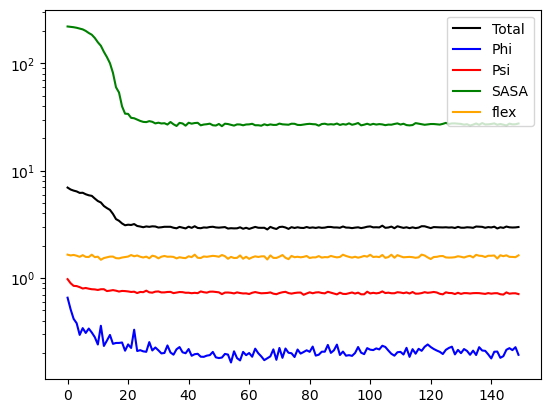

In [9]:
plt.plot(multi_metrics["val"]["loss"], c="black", label="Total")
plt.plot(multi_metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(multi_metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(multi_metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(multi_metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [10]:
print("Mean Predictor")
multi_mean_phi_rmse, multi_mean_psi_rmse, multi_mean_sasa_rmse, multi_mean_flex_rmse, multi_mean_preds = \
    evaluate_model((multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor), multi_test)
print(multi_mean_phi_rmse, multi_mean_psi_rmse, multi_mean_sasa_rmse, multi_mean_flex_rmse)

print("Median Predictor")
multi_median_phi_rmse, multi_median_psi_rmse, multi_median_sasa_rmse, multi_median_flex_rmse, multi_median_preds = \
    evaluate_model((multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor), multi_test)
print(multi_median_phi_rmse, multi_median_psi_rmse, multi_median_sasa_rmse, multi_median_flex_rmse)

print("VonMisesSweetNet")
multi_model_phi_rmse, multi_model_psi_rmse, multi_model_sasa_rmse, multi_model_flex_rmse, multi_model_preds = \
    evaluate_model(multi_model, multi_test)
print(multi_model_phi_rmse, multi_model_psi_rmse, multi_model_sasa_rmse, multi_model_flex_rmse)

Mean Predictor
0 0 47.47243275981165 1.8463894234697955
Median Predictor
0 0 48.6334846606489 1.942044404095067
VonMisesSweetNet
1143 / 1143
0 0 27.400810402177093 1.6156290449958004


## Visulaze Multi-Conformer VonMisesSweetNet

In [11]:
def ramachandran_plot(
        disaccharide: str, 
        structure_graphs: list[nx.DiGraph],
        density: bool = True,
        ax: plt.Axes = None,
        mode: str = None,
        split: str = None,
        conf: str = None,
) -> plt.Figure:
    """Generate a Ramachandran plot for a specific disaccharide linkage.
    Args:
    disaccharide: String representing the disaccharide (e.g., "Fuc(a1-2)Gal")
    structure_graphs: Dictionary of glycan structure graphs
    density: Whether to show density contours (default: True)
    filepath: Path to save the figure (optional)
    Returns:
    Matplotlib figure object
    """
    phi_angles, psi_angles = extract_torsion_angles(disaccharide, dict(enumerate(structure_graphs)))
    if not phi_angles or not psi_angles:
        raise ValueError(f"No torsion angles found for disaccharide: {disaccharide}")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create density contours if requested
    if density and len(phi_angles) > 3:
        # Calculate the point density
        xy = np.vstack([phi_angles, psi_angles])
        z = stats.gaussian_kde(xy)(xy)
        # Sort the points by density for better visualization
        idx = z.argsort()
        x_sorted, y_sorted, z_sorted = np.array(phi_angles)[idx], np.array(psi_angles)[idx], z[idx]
        # Clear the previous plot and redraw with density coloring
        ax.clear()
        scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        # Create the scatter plot
        ax.scatter(phi_angles, psi_angles, alpha=0.7, s=30, c='blue', edgecolor='white')

    # Set plot limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi (°)')
    ax.set_ylabel('Psi (°)')
    ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    ax.grid(alpha=0.3)
    # Add the origin lines
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    # Add statistics
    stats_text = (
        f"n = {len(phi_angles)}\n"
        f"Mean φ = {np.mean(phi_angles):.1f}° ± {np.std(phi_angles):.1f}°\n"
        f"Mean ψ = {np.mean(psi_angles):.1f}° ± {np.std(psi_angles):.1f}°"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

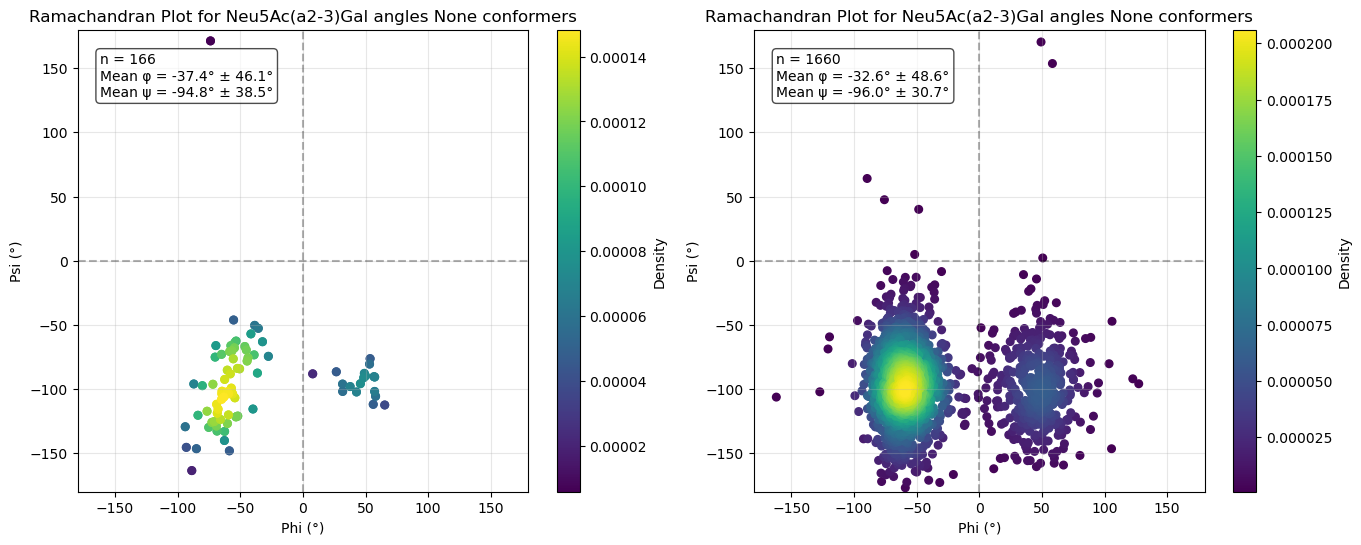

In [12]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=multi_model_preds, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

0.9144510991022081


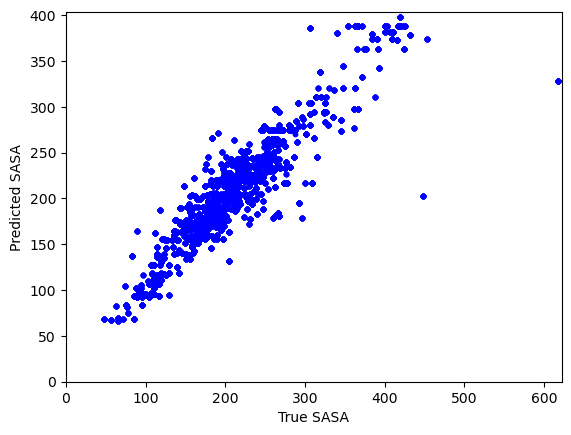

In [13]:
def plot_value_distributions(
        true_graphs: list[nx.DiGraph],
        pred_graphs: list[nx.DiGraph],
        value_name: str,
):
    true_values, pred_values = [], []
    for true_graph, pred_graph in zip(true_graphs, pred_graphs):
        for n in true_graph.nodes:
            if value_name in true_graph.nodes[n] and value_name in pred_graph.nodes[n]:
                true_values.append(true_graph.nodes[n][value_name])
                pred_values.append(pred_graph.nodes[n][value_name])
    
    plt.scatter(true_values, pred_values, s=10, marker="o", c="blue")
    print(np.corrcoef(true_values, pred_values)[0, 1])
    plt.xlim(0, min(5 + max(true_values), 1.2 * max(true_values)))
    plt.ylim(0, min(5 + max(pred_values), 1.2 * max(pred_values)))
    plt.xlabel(f"True {value_name}")
    plt.ylabel(f"Predicted {value_name}")

plot_value_distributions(
    [t[1] for t in multi_test], 
    [multi_model_preds[x] for x in range(0, len(multi_model_preds), 10)],
    value_name="SASA",
)

0.5131467084417355


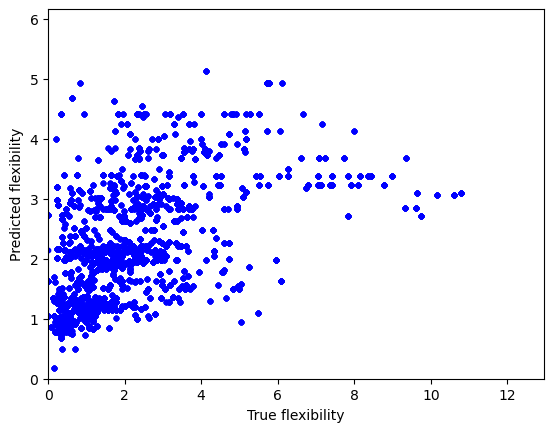

In [15]:
plot_value_distributions(
    [t[1] for t in multi_test], 
    [multi_model_preds[x] for x in range(0, len(multi_model_preds), 10)],
    value_name="flexibility",
)